In [553]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from utils import Geometry, simulate_events, classify_events

# radius of a circle that contains all the grid points
radius = 2.3
geometry = Geometry.create(spacing=1, radius=radius, jitter=0.1)

## some useful functions:

In [562]:

def gen_and_sim(size=1_000_000, gen_filter=None, keep_prob=0, seed=None):
    
    """
        generate and simulate <size> background events
        gen_filter: a function taking `angle`, `impact` and `log_energy`
            as input and returning a bool. If the event passes gen filter
            it will be simulated.
        keep_prob: if gen_filter is given, failed events may also be passed
            to simulation with probability equal to <drop_prob>
            
        TODO:
            input random seed for reproducibility.
    """
    if seed:
        np.random.seed(seed)
    # sample uniformly in direction
    angle = np.random.uniform(0, 2 * np.pi, size=size)
    # sample uniformly in impact parameter
    impact = np.random.uniform(-radius - 1, radius + 1, size=size)
    # particle "energy"
    log_energy = np.random.uniform(2, 5, size=size)

    weights = None
    if gen_filter != None:
        passed = gen_filter(angle, impact, log_energy)
        gen_filter_pass_rate = passed.sum()/len(passed)

        weights = np.where(passed>0, 1.0/passed,0)
        filter_mask = np.random.random(size=len(passed)) < passed
        print(f'Gen filter passing rate: {gen_filter_pass_rate}')
        if keep_prob:
            if keep_prob <0 or keep_prob>1:
                raise ValueError(f"keep_prob should be between 0 and 1 but it was: {keep_prob}")
                
            keep_prob_array = np.where(passed,0, keep_prob)
            keep_mask = np.random.random(size=len(passed)) < keep_prob_array
            mask = keep_mask + filter_mask
            weights += keep_mask*1.0/keep_prob
            weights = weights[mask]
            
            print(f'   including prescaled: {mask.sum()/len(mask)}')
            #return mask, keep_prob_array
        else:
            mask = filter_mask
            weights = weights[mask]
            
        angle  = angle[mask]
        impact = impact[mask]
        log_energy = log_energy[mask]
    
    enter, exit, loss_position, fiducial_signal, veto_signal = simulate_events(
        geometry, radius + 1, angle, impact, log_energy
    )
    in_volume, triggered, vetoed = classify_events(
        geometry, loss_position, fiducial_signal, veto_signal
    )
    unvetoed = triggered & ~vetoed

    df = pd.DataFrame(
        {
            "angle": angle,
            "impact": impact,
            "log_energy": log_energy,
            "in_volume": in_volume,
            "triggered": triggered,
            "vetoed": vetoed,
        }
    )
    
    if np.any(weights):
        #normalize the weights and add to the DF
        weights = weights*size/np.sum(weights)
        df['weights'] = weights
    else:
        df['weights'] = 1.0
    return df



def inspect(df, weighted=True, title=""):
    if weighted:
        n_df         = df.weights.sum()
        n_vetoed     = np.sum(df.vetoed*df.weights)
        n_triggered  = np.sum( df.triggered*df.weights)
        n_unvetoed   = np.sum( (df.triggered & ~df.vetoed)*df.weights)
        n_undetected = np.sum( (~df.triggered & ~df.vetoed)*df.weights)
    else:
        n_df = len(df)
        n_vetoed     = np.sum(df.vetoed)
        n_triggered  = np.sum( df.triggered)
        n_unvetoed   = np.sum( (df.triggered & ~df.vetoed) )
        n_undetected = np.sum( (~df.triggered & ~df.vetoed) )
    print(
f"""---------- {title}
vetoed:      {n_vetoed/n_df * 100:0.1f}%
undetected:  {n_undetected/n_df*100:0.1f}%
triggered:   {n_triggered/n_df * 100:0.1f}%
unvetoed:    {n_unvetoed/n_df * 100:0.1f}%
useful frac: {np.sum( (df.triggered & ~df.vetoed) )/len(df) *100:0.1f}%
"""
        )
    ####

    
def cut_eff(df, cut_or_mask, weights='weights'):
    """
        returns the efficiency of the given <cut_or_mask>
        
    """
    if isinstance(cut_or_mask, str):
        mask = df.eval(cut_or_mask)
    else:
        mask = cut_or_mask
        if len(mask)!=len(df):
            raise ValueError("The dimension of df and given mask don't match")
    #print(mask)
    if isinstance(weights, str):
        weights = df[weights]
    
    if np.any(weights):
        n_tot  = np.sum(weights)
        n_pass = np.sum(mask*weights ) 
    else:
        n_tot = len(df)
        n_pass = len(df[mask])
    eff = n_pass/n_tot
    return eff



## Simple case:

A simple way to increase the fraction of useful events ( $\frac{N_{unveto}}{N_{generated}}$ ) is to apply a simple cut to the generated events (for example `abs(impact)<2 & log_energy<4.5` ) before passing the events for detector simulation. The problem, is that this will create a "fully biased" sample, with no easy way of getting back information of the kinematics of the lost events. One work around, that we can "prescale" the events that don't pass the generator filter, instead of dropping them, i.e we keep them with a certain probability (`drop_prob`). Then, when we wan to calculate the unbiased passing fraction, we can simply reweight the events (including the prescaled ones) to obtain the correct values. The distributions would suffer from lower statistics in regions that we have cut out. 

In [563]:
gen_filter = lambda angle, impact, log_energy: (abs(impact)<2) & (log_energy<4.5)

## A tighter cut still gives correct passing-rates, but sufferrs from statistics in
## regions of interest:
## gen_filter = lambda angle, impact, log_energy: (abs(impact)<1.5) & (log_energy<3.5)

seed=1

df_unbiased = gen_and_sim(1_000_000, seed=seed)

df_biased = gen_and_sim(1_000_000, gen_filter, keep_prob=0.01, seed=seed)

df_fullybiased = gen_and_sim(1_000_000, gen_filter, keep_prob=0.0, seed=seed)

/tmp/ipykernel_39427/4084972613.py:28: RuntimeWarning: divide by zero encountered in divide
  weights = np.where(passed>0, 1.0/passed,0)


Gen filter passing rate: 0.504539
   including prescaled: 0.509474


/tmp/ipykernel_39427/4084972613.py:28: RuntimeWarning: divide by zero encountered in divide
  weights = np.where(passed>0, 1.0/passed,0)


Gen filter passing rate: 0.504539


In [556]:

    
inspect(df_unbiased, title='Unbiased Sample:')

inspect(df_fullybiased, title='Fully Biased: (no prescaling)')

inspect(df_biased, weighted=False, title='Biased: (no reweighting)')

inspect(df_biased, title='Biased Sample: (correcting the bias by reweighting the dropped events)')





---------- Unbiased Sample:
vetoed:      62.8%
undetected:  36.2%
triggered:   12.1%
unvetoed:    1.0%
useful frac: 1.0%

---------- Fully Biased: (no prescaling)
vetoed:      75.4%
undetected:  22.6%
triggered:   15.9%
unvetoed:    2.0%
useful frac: 2.0%

---------- Biased: (no reweighting)
vetoed:      75.2%
undetected:  22.8%
triggered:   15.9%
unvetoed:    2.0%
useful frac: 2.0%

---------- Biased Sample: (correcting the bias by reweighting the dropped events)
vetoed:      nan%
undetected:  nan%
triggered:   nan%
unvetoed:    nan%
useful frac: 2.0%



/tmp/ipykernel_39427/3772800754.py:94: RuntimeWarning: invalid value encountered in double_scalars
  f"""---------- {title}


fraction of usefull events: 1.01%


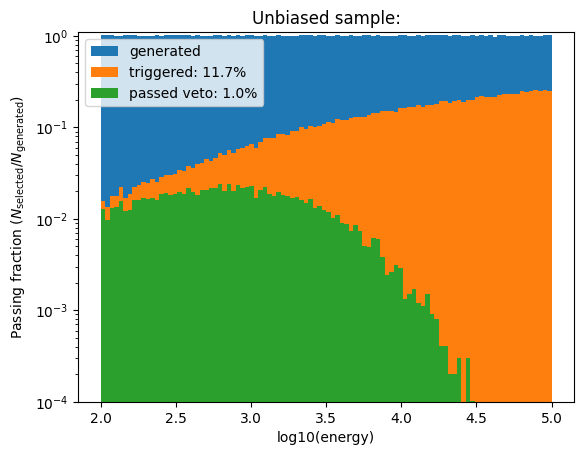

In [487]:
df = df_unbiased

triggered = df.triggered
unvetoed = df.triggered & ~df.vetoed

bins = np.linspace(2, 5, 101)
weight = len(bins) / len(df)

df["log_energy"].plot.hist(bins=bins, weights=np.ones(len(df)) * weight*df.weights, label='generated')
df["log_energy"][triggered].plot.hist(bins=bins, weights=np.ones(len(df[triggered])) * weight*df.weights[triggered], label=f'triggered: {df.weights[triggered].sum()/len(df)*100:.1f}%')
df["log_energy"][unvetoed].plot.hist(bins=bins, weights=np.ones(len(df[unvetoed])) * weight*df.weights[unvetoed], label=f'passed veto: {df.weights[unvetoed].sum()/len(df)*100:.1f}%')

#df["log_energy"][triggered].plot.hist(bins=bins, weights=np.ones(len(df[triggered])) * weight, label=f'triggered: {triggered.sum()/df.size*100:.1f}%')
#df["log_energy"][unvetoed].plot.hist(bins=bins, weights=np.ones(len(df[unvetoed])) * weight, label=f'passed veto: {unvetoed.sum()/df.size*100:.1f}%')


plt.semilogy()
plt.xlabel("log10(energy)")
plt.ylabel(r"Passing fraction $(N_{\rm selected}/N_{\rm generated})$")
plt.legend()
plt.ylim(1E-4,1.1)
plt.title('Unbiased sample:')
useful_fraction = unvetoed.sum()/len(df)
print(f"fraction of usefull events: {useful_fraction*100:0.2f}%")

The fully biased sample does not contain any of the filtered events, which makes it more difficult (impossible?) to obtain the unbiased passing rate
fraction of usefull events: 1.97%


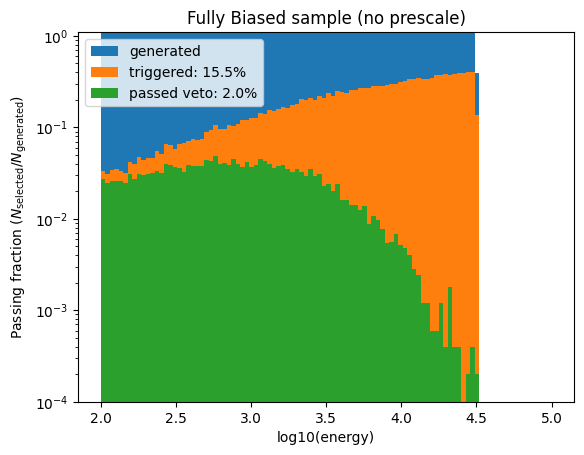

In [491]:
df = df_fullybiased

triggered = df.triggered
unvetoed = df.triggered & ~df.vetoed

bins = np.linspace(2, 5, 101)
weight = len(bins) / df.weights.sum()
n_generated = 1E6

df["log_energy"].plot.hist(bins=bins, weights=np.ones(len(df))* weight *df.weights   , label='generated')
df["log_energy"][triggered].plot.hist(bins=bins, weights=np.ones(len(df[triggered])) * weight*df.weights[triggered], label=f'triggered: {df.weights[triggered].sum()/df.weights.sum()*100:.1f}%')
df["log_energy"][unvetoed].plot.hist(bins=bins, weights=np.ones(len(df[unvetoed])) * weight*df.weights[unvetoed], label=f'passed veto: {df.weights[unvetoed].sum()/df.weights.sum()*100:.1f}%')

#df["log_energy"][triggered].plot.hist(bins=bins, weights=np.ones(len(df[triggered])) * weight, label=f'triggered: {triggered.sum()/df.size*100:.1f}%')
#df["log_energy"][unvetoed].plot.hist(bins=bins, weights=np.ones(len(df[unvetoed])) * weight, label=f'passed veto: {unvetoed.sum()/df.size*100:.1f}%')


plt.semilogy()
plt.xlabel("log10(energy)")
plt.ylabel(r"Passing fraction $(N_{\rm selected}/N_{\rm generated})$")
plt.legend()
plt.ylim(1E-4,1.1)
plt.title("Fully Biased sample (no prescale)")
caption = "The fully biased sample does not contain any of the filtered events, which makes it more difficult (impossible?) to obtain the unbiased passing rate"
print(caption)

useful_fraction = unvetoed.sum()/len(df)
print(f"fraction of usefull events: {useful_fraction*100:0.2f}%")

The biased sample without reweighting gives different passing-rates than the unbiased sample:
fraction of usefull events: 1.79%


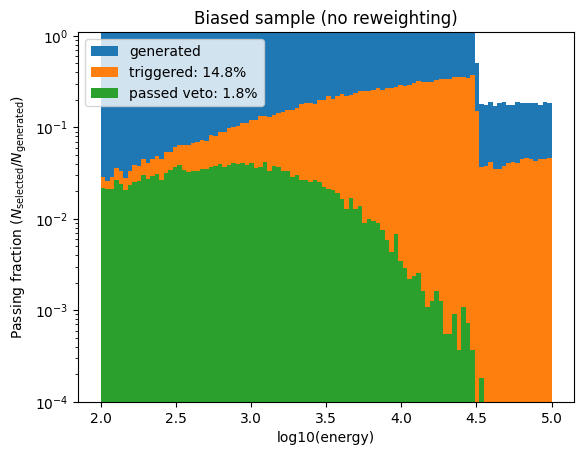

In [492]:
df = df_biased

triggered = df.triggered
unvetoed = df.triggered & ~df.vetoed

bins = np.linspace(2, 5, 101)
weight = len(bins) / len(df)

df["log_energy"].plot.hist(bins=bins, weights=np.ones(len(df)) * weight, label='generated')
df["log_energy"][triggered].plot.hist(bins=bins, weights=np.ones(len(df[triggered])) * weight, label=f'triggered: {triggered.sum()/len(df)*100:.1f}%')
df["log_energy"][unvetoed].plot.hist(bins=bins, weights=np.ones(len(df[unvetoed])) * weight, label=f'passed veto: {unvetoed.sum()/len(df)*100:.1f}%')

#df["log_energy"][triggered].plot.hist(bins=bins, weights=np.ones(len(df[triggered])) * weight, label=f'triggered: {triggered.sum()/df.size*100:.1f}%')
#df["log_energy"][unvetoed].plot.hist(bins=bins, weights=np.ones(len(df[unvetoed])) * weight, label=f'passed veto: {unvetoed.sum()/df.size*100:.1f}%')


plt.semilogy()
plt.xlabel("log10(energy)")
plt.ylabel(r"Passing fraction $(N_{\rm selected}/N_{\rm generated})$")
plt.ylim(1E-4,1.1)
plt.legend()
plt.title("Biased sample (no reweighting)")
caption = "The biased sample without reweighting gives different passing-rates than the unbiased sample:"
print(caption)
useful_fraction = unvetoed.sum()/len(df)
print(f"fraction of usefull events: {useful_fraction*100:0.2f}%")

The biased sample with the *correct* reweighting gives compatible passing ratios, while having slightly larger *useful* fraction of events.
fraction of usefull events: 1.79%


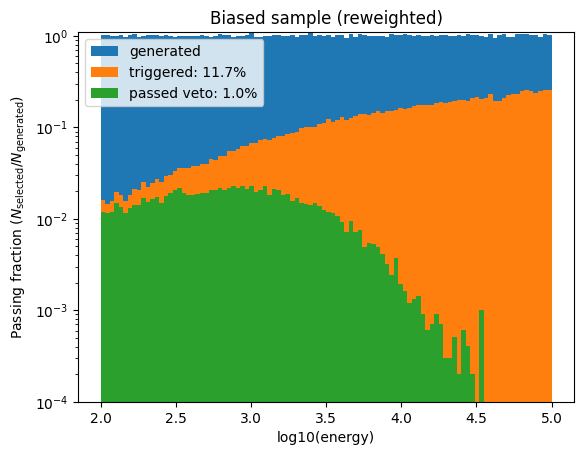

In [493]:
df = df_biased

triggered = df.triggered
unvetoed = df.triggered & ~df.vetoed

bins = np.linspace(2, 5, 101)
weight = len(bins) / df.weights.sum()

df["log_energy"].plot.hist(bins=bins, weights=np.ones(len(df)) * weight*df.weights, label='generated')
df["log_energy"][triggered].plot.hist(bins=bins, weights=np.ones(len(df[triggered])) * weight*df.weights[triggered], label=f'triggered: {df.weights[triggered].sum()/df.weights.sum()*100:.1f}%')
df["log_energy"][unvetoed].plot.hist(bins=bins, weights=np.ones(len(df[unvetoed])) * weight*df.weights[unvetoed], label=f'passed veto: {df.weights[unvetoed].sum()/df.weights.sum()*100:.1f}%')

plt.semilogy()
plt.xlabel("log10(energy)")
plt.ylabel(r"Passing fraction $(N_{\rm selected}/N_{\rm generated})$")
plt.legend()
plt.ylim(1E-4,1.1)
plt.title("Biased sample (reweighted)")

caption = f"The biased sample with the *correct* reweighting gives compatible passing ratios, while having slightly larger *useful* fraction of events."
useful_fraction = unvetoed.sum()/len(df)
print(caption)
print(f"fraction of usefull events: {useful_fraction*100:0.2f}%")

## Getting deep? 

Maybe might also be able to gain by doing more complicated selection using a Neural Net trained using the simulated events.
Here we load a model with pretrained weights using the following variables:
    `impact`, `angle`, `log_energy`, `closest_approach_x`, `closest_approach_y`
The model then can give us a probability between 0, 1 where for being an event of interest (unvetoed).
We can then use this probability for filtering then event and also use the probability to weight the event.

But the question is how much do we actually gain in CPU time by this? 


In [560]:
# Load Model

import tensorflow as tf
import tensorflow.keras as keras

#model_name = "Model_12L_Binary"
model_name = "Model_6L_Binary"
model = keras.models.load_model(f"{model_name}/model.h5")
model.load_weights(f"{model_name}/weights.h5")




In [561]:
#
# create the gen_filter based on the NN model
#

def gen_filter_nn(angle, impact, log_energy):
#if True:
    d = np.stack((-np.cos(angle), -np.sin(angle)), axis=-1)
    closest_approach = impact[..., None] * np.stack((-d[..., 1], d[..., 0]), axis=-1)
    
    closest_approach_x = closest_approach[..., 0]
    closest_approach_y = closest_approach[..., 1]
    X = np.stack([angle, impact, log_energy, closest_approach_x, closest_approach_y], axis=1)
    probs = model.predict(X).reshape(len(X))
    return probs

df_nn = gen_and_sim(size=1_000_000, gen_filter=gen_filter_nn, keep_prob=0.01, seed=seed)

31250/31250 [==============================] - 41s 1ms/step


/tmp/ipykernel_39427/2736575470.py:33: RuntimeWarning: divide by zero encountered in divide
  weights = np.where(passed>0, 1.0/passed,0)


Gen filter passing rate: 0.2707885
   including prescaled: 0.276239


In [565]:
inspect(df_nn)

---------- 
vetoed:      59.5%
undetected:  39.4%
triggered:   11.2%
unvetoed:    1.1%
useful frac: 3.0%



The biased sample with the *correct* reweighting gives compatible passing ratios, while having slightly larger *useful* fraction of events.
fraction of usefull events: 2.96%
Here seems like tail behavior is not as wel described... possible overtraining in the model?


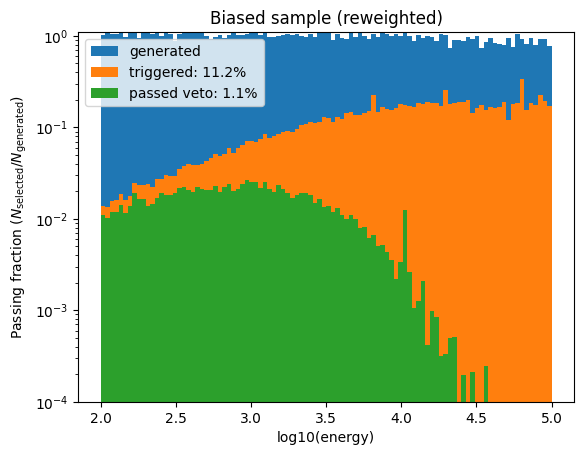

In [566]:
df = df_nn

triggered = df.triggered
unvetoed = df.triggered & ~df.vetoed

bins = np.linspace(2, 5, 101)
weight = len(bins) / df.weights.sum()

df["log_energy"].plot.hist(bins=bins, weights=np.ones(len(df)) * weight*df.weights, label='generated')
df["log_energy"][triggered].plot.hist(bins=bins, weights=np.ones(len(df[triggered])) * weight*df.weights[triggered], label=f'triggered: {df.weights[triggered].sum()/df.weights.sum()*100:.1f}%')
df["log_energy"][unvetoed].plot.hist(bins=bins, weights=np.ones(len(df[unvetoed])) * weight*df.weights[unvetoed], label=f'passed veto: {df.weights[unvetoed].sum()/df.weights.sum()*100:.1f}%')

plt.semilogy()
plt.xlabel("log10(energy)")
plt.ylabel(r"Passing fraction $(N_{\rm selected}/N_{\rm generated})$")
plt.legend()
plt.ylim(1E-4,1.1)
plt.title("Biased sample (reweighted)")

caption = f"The biased sample with the *correct* reweighting gives compatible passing ratios, while having slightly larger *useful* fraction of events."
useful_fraction = unvetoed.sum()/len(df)
print(caption)
print(f"fraction of usefull events: {useful_fraction*100:0.2f}%")
print(f"Here seems like tail behavior is not as wel described... possible overtraining in the model?")